In [78]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [84]:
p = [1.0, 1.0, 1.0]
A = 100
D = 4000000

nO = len(p)
nnO = math.pow(nO, nO)
aO = A * nnO * nnO
negb = aO - nnO

In [85]:
def computeK(amplificationParameter, a, negb, n, prices):
    k = a/min(prices) + 1
    for i in range(255):
        T, Tl, P, Pl, Tn, Tn1, alpha = computeKparams(amplificationParameter, k, a, negb, n, prices)

        fk = Tn1 * P
        
        if(n%2 == 1):
            fk -= alpha
        else:
            fk += alpha

        flk = Tn*((n+1)*Tl*P + T*Pl)
        
        newK = k - fk / flk
        
        if (abs(newK - k) < math.pow(10, -5)):
            print(T, Tl, P, Pl, Tn, Tn1, alpha)
            return newK
        k = newK   
    raise RuntimeError("KDidntConverge()")

def computeF_k(amplificationParameter, k, a, negb, n, prices):
    T, Tl, P, Pl, Tn, Tn1, alpha = computeKparams(amplificationParameter, k, a, negb, n, prices)

    fk = Tn1 * P
        
    if(n%2 == 1):
        fk -= alpha
    else:
        fk += alpha

    return fk

def computeBalancesForPrices(amplificationParameter, invariant, a, negb, n, prices):
    k = computeK(amplificationParameter, a, negb, n, prices)
    print('k:', k)
    
    sumPriceDivision = 0
    for pi in prices:
        sumPriceDivision += a/(k*pi - a)
    
    balancesForPrices = np.zeros_like(prices)
    for i in np.arange(0, n):
        balancesForPrices[i] = (negb*invariant/(a - k*p[i]))/(1-sumPriceDivision)

    return balancesForPrices

def computeKparams(amplificationParameter, k, a, negb, n, prices):
    T = 1
    Tl = 0
    P = 1
    Pl = 0
    for pi in prices:
        ri = pi/a
        den = (k*ri - 1)
        T -= 1/den
        Tl += ri/(den*den)
        P = P * den
        Pl += ri/den
    Pl = Pl*P

    c = negb/a
    Tn = 1
    for j in range(n):
        Tn = Tn * T
        c = c * (negb/a)
    Tn1 = Tn * T
    alpha = a*c
    return T, Tl, P, Pl, Tn, Tn1, alpha

In [86]:
k_array = np.arange(7.33e4, 1e8, 1e3)
f_k_array = np.zeros_like(k_array)
for i in np.arange(0, len(k_array)):
    ki = k_array[i]
    f_k_array[i] = computeF_k(A, ki, aO, negb, nO, p)

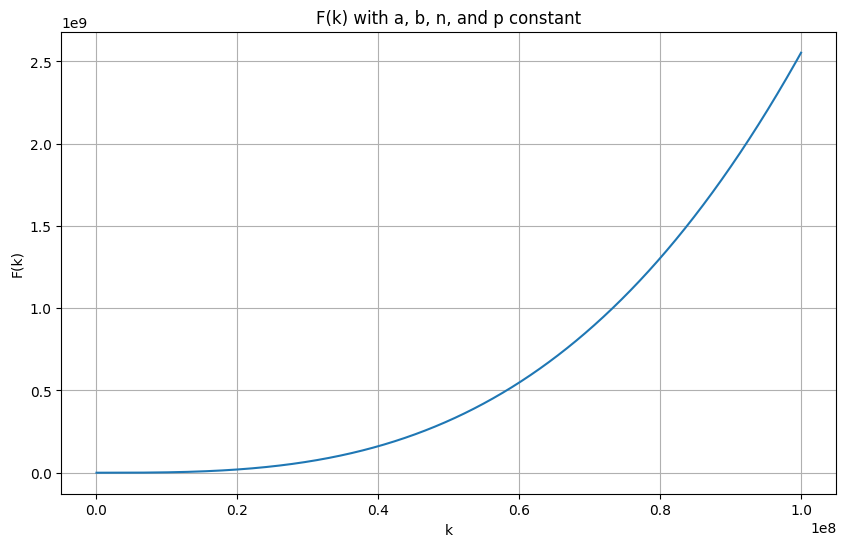

In [87]:
plt.figure(figsize=(10, 6))  # Set figure size for better visibility
plt.plot(k_array, f_k_array)
plt.xlabel('k')
plt.ylabel('F(k)')
plt.title('F(k) with a, b, n, and p constant')
plt.grid(True)  # Add grid for better readability
plt.show()

In [88]:
balancesForPrices = computeBalancesForPrices(A, D, aO, negb, nO, p)
print('balancesForPrices', balancesForPrices)

-2699.000000024398 33.333333333935755 1.3717421124456668e-09 5.080526342437267e-11 -19661138099.53319 53065411731119.78 72792.05998518656
k: 72981.0
balancesForPrices [1333333.33333333 1333333.33333333 1333333.33333333]


In [61]:
def compute_invariant(A, balances):
    # Calculate the sum of balances
    total_balance = sum(balances)
    n = len(balances)
    prodBalances = 1
    for i in range(n):
        prodBalances = prodBalances * balances[i]

    # Initial invariant
    D = total_balance

    # Iteratively compute the invariant
    for i in range(500):
        fD = math.pow(D, n+1)/(math.pow(n, n)*prodBalances) + A*math.pow(n, n)*D - D - A*math.pow(n, n)*total_balance
        flD = (n+1)*math.pow(D, n)/(math.pow(n, n)*prodBalances) + A*math.pow(n, n) - 1
        newD = D - fD/flD

        # Check for convergence
        if abs(newD - D) < math.pow(10, -5):
            return newD
        D = newD

    raise RuntimeError("StableInvariantDidntConverge()")

In [62]:
def computeBalance(A, balances, D, tokenIndex):
    x = 1
    n = len(balances)
    nn = math.pow(n, n)
    prodBalances = 1
    sumBalances = 0
    for i in range(len(balances)):
        if (i != tokenIndex):
            prodBalances = prodBalances * balances[i]
            sumBalances += balances[i]
        
    for i in range(255):
        fx = A*nn*(sumBalances+x) + D - A*nn*D - math.pow(D, n+1)/(nn*prodBalances*x)
        flx = A*nn + math.pow(D, n+1)/(nn*prodBalances*math.pow(x,2))
        newX = x - fx/flx
        if (abs(x - newX) < math.pow(10, -5)):
            return newX
        x = newX
    raise RuntimeError("StableInvariantDidntConverge()")

def computeOutGivenIn(A, balances, D, tokenInIndex, tokenOutIndex, amountIn):
    newBalances = balances.copy()
    newBalances[tokenInIndex] = newBalances[tokenInIndex] + amountIn
    newBalances[tokenOutIndex] = computeBalance(A, newBalances, D, tokenOutIndex)
    return balances[tokenOutIndex] - newBalances[tokenOutIndex]

In [63]:
newD = compute_invariant(A, balancesForPrices)
print('old invariant', D)
print('new invariant', newD)
tvl = 0
for i in range(len(p)):
    tvl += p[i]*balancesForPrices[i]

print('TVL', tvl)

amountIn = 0.0001
pBase = p[0]
pFinal = np.zeros_like(p)
pFinal[0] = pBase
for i in range(len(p) - 1):
    amountOut = computeOutGivenIn(A, balancesForPrices, D, 0, i+1, amountIn)
    pFinal[i+1] = pBase * amountIn/amountOut

print('final prices', pFinal)


old invariant 4000000
new invariant 3999999.999999993
TVL 5025900.745882739
final prices [5.00000000e-01 1.00018427e-01 6.00107209e+00 8.00119437e+03]
